In [192]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from pandas import DataFrame
from torch import Tensor

In [193]:
# remove after debugging
SEED = 42

In [194]:
# Load the data into a DataFrame if necessary

def load_data(dataset:int): 
    """
    loads data into pd dataFrame. either original or pca

    Args:
        dataset (int): 0 = original data, 1 = PCA data
    """

    data_orig = pd.read_csv(filepath_or_buffer='final_data_only_tpm.csv')

    data_pca = pd.read_csv(filepath_or_buffer='pca_data.csv')
    data_pca.drop(data_pca.columns[0], axis=1, inplace=True)

    # choose dataset according to user input (parameter dataset)
    if dataset==0:
        print("loading original data")
        data = data_orig 
    else: 
        print("loading pca data")
        data = data_pca

    # change ctargel col "cancer_type" from string label to int val
    map = {
        "kidney chromophobe": 0,
        "kidney renal papillary cell carcinoma": 1,
        "kidney renal clear cell carcinoma": 2,
    }
    data1 = data.copy()
    data1['cancer_type'] = data1['cancer_type'].replace(map)
    
    return data1

def split_data(data: DataFrame, normalize=False, seed:int=None) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    returns Train Test splittet Tensors

    Args:
        data (pd Dataframe): whole dataset

    Returns:
        torch tensor: 4-tuple of train test data
    """

    """
    # Split the data into training and validation sets
    train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=seed)

    # dataloader
    batch_size = 128
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    """
    # or

    # Split the data into features (X) and target variable (y)
    X = data.drop('cancer_type', axis=1)
    y = data['cancer_type']

    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.2, random_state=seed)

    # normalizing data: no effect for pca
    if normalize:
        scaler = StandardScaler()
        X_train_pd = pd.DataFrame(scaler.fit_transform(X_train_pd))
        X_test_pd = pd.DataFrame(scaler.fit_transform(X_test_pd))

    X_train_tens = torch.tensor(X_train_pd.values).float()
    X_test_tens = torch.tensor(X_test_pd.values).float()
    y_train_tens = torch.tensor(y_train_pd.values)
    y_test_tens = torch.tensor(y_test_pd.values)

    # Print the shapes of the datasets
    print("  X_train:", X_train_tens.shape)
    print("  X_test:", X_test_tens.shape)
    print("  y_train:", y_train_tens.shape)
    print("  y_test:", y_test_tens.shape)

    return (X_train_tens, X_test_tens, y_train_tens, y_test_tens)


# Step 1 Loading data
print("Step 1: Loading data")

# load anyway
#data = load_data(0)

# load if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(0)

# Step 2 Splitting data & formatting to tensor
print("Step 2: Splitting data & formatting to tensor")

X_train, X_test, y_train, y_test = split_data(data, normalize=True, seed=SEED)


Step 1: Loading data
Step 2: Splitting data & formatting to tensor
  X_train: torch.Size([822, 60660])
  X_test: torch.Size([206, 60660])
  y_train: torch.Size([822])
  y_test: torch.Size([206])


In [204]:
# Step 3: Define Variables
print("Step 3: Define Variables")

HIDDEN_UNITS = 64
NUM_FEATURES = X_train.shape[1]     # pca=1028 orig=60660
NUM_CLASSES = len(set(y_train.tolist()))     # cancer types
DEVICE = "cpu"
LR = 0.0005                         # learning Rate
EPOCHS = 50

print("HIDDEN_UNITS: ", HIDDEN_UNITS)
print("NUM_FEATURES: ", NUM_FEATURES)
print("NUM_CLASSES: ", NUM_CLASSES)
print("DEVICE: ", DEVICE)
print("LR: ", LR)
print("EPOCHS: ", EPOCHS)

Step 3: Define Variables
HIDDEN_UNITS:  64
NUM_FEATURES:  60660
NUM_CLASSES:  3
DEVICE:  cpu
LR:  0.0005
EPOCHS:  50


In [205]:
# Step 4: Define the Neural Network Class
print("Step 4: Define the Neural Network Class")

class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleClassifier, self).__init__()

        """self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            #nn.ReLU(), 
            #nn.Sigmoid(),
            #nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=num_classes),
            nn.Softmax(dim=1)
        )"""

        self.non_linear_layer_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )

        """kernel_size = 3
        n_filters = 32
        conv_out_len = num_classes - kernel_size + 1
        self.convolutional_layer_stack = nn.Sequential(
            nn.Conv1d(
                in_channels=input_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
            ),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=n_filters * conv_out_len, out_features=num_classes),
        )"""
        
    def forward(self, x):
        # Define forward pass
        return self.non_linear_layer_stack(x)
    

Step 4: Define the Neural Network Class


In [208]:
# Step 5: Initialize the Neural Network
print("Step 5: Initialize the Neural Network\n")

torch.manual_seed(SEED)

model = SimpleClassifier(NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES)
print("Neural Network Architecture:")
print(model)

# Step 6: Define Loss Function and Optimizer
print("\nStep 6: Define Loss Function and Optimizer")

# CrossEntropyLoss is commonly used for classification problems
criterion = nn.CrossEntropyLoss()  # loss funktion

# Adam optimizer is a popular choice for optimization
optimizer = optim.Adam(model.parameters(), lr=LR)

print("loss function: ", criterion)
print("optimizer: ", optimizer)



Step 5: Initialize the Neural Network

Neural Network Architecture:
SimpleClassifier(
  (non_linear_layer_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=60660, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)

Step 6: Define Loss Function and Optimizer
loss function:  CrossEntropyLoss()
optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


In [198]:
## model pre testing
""""""
# Perform a single forward pass on the data 
print(model(X_train.to(DEVICE))[:5])
print(model(X_train.to(DEVICE))[0].shape, NUM_CLASSES , "\n")

# Make prediction logits with model
y_logits_test = model(X_test.to(DEVICE))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits_test, dim=1) 
print(y_logits_test[:5])
print(y_pred_probs[:5], "\n")

# Sum the first sample output of the softmax activation function 
print(torch.sum(y_pred_probs[0]), "\n")

# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]), "\n")

tensor([[0.3767, 0.2325, 0.3907],
        [0.2422, 0.4684, 0.2894],
        [0.3672, 0.2757, 0.3571],
        [0.4230, 0.3292, 0.2478],
        [0.5033, 0.2558, 0.2409]], grad_fn=<SliceBackward0>)
torch.Size([3]) 3 

tensor([[0.3639, 0.3041, 0.3320],
        [0.3426, 0.3090, 0.3484],
        [0.3601, 0.2178, 0.4220],
        [0.3286, 0.3118, 0.3596],
        [0.3169, 0.2812, 0.4019]], grad_fn=<SliceBackward0>)
tensor([[0.3436, 0.3236, 0.3328],
        [0.3364, 0.3253, 0.3384],
        [0.3412, 0.2959, 0.3629],
        [0.3317, 0.3262, 0.3422],
        [0.3275, 0.3160, 0.3565]], grad_fn=<SliceBackward0>) 

tensor(1.0000, grad_fn=<SumBackward0>) 

tensor([0.3436, 0.3236, 0.3328], grad_fn=<SelectBackward0>)
tensor(0) 



Step 7: Training the Neural Network with Test Printing
Epoch: 5 | Loss: 0.67058, Acc: 87.59% | Test Loss: 0.69402, Test Acc: 84.95%
Epoch: 10 | Loss: 0.63669, Acc: 91.12% | Test Loss: 0.65586, Test Acc: 89.32%
Epoch: 15 | Loss: 0.61875, Acc: 93.31% | Test Loss: 0.64717, Test Acc: 89.81%
Epoch: 20 | Loss: 0.59930, Acc: 95.13% | Test Loss: 0.62702, Test Acc: 92.23%
Epoch: 25 | Loss: 0.59441, Acc: 95.62% | Test Loss: 0.62418, Test Acc: 92.23%
Epoch: 30 | Loss: 0.58889, Acc: 96.11% | Test Loss: 0.62714, Test Acc: 91.75%
Epoch: 35 | Loss: 0.58554, Acc: 96.59% | Test Loss: 0.62275, Test Acc: 92.72%
Epoch: 40 | Loss: 0.58389, Acc: 96.72% | Test Loss: 0.61627, Test Acc: 93.69%
Epoch: 45 | Loss: 0.58167, Acc: 96.96% | Test Loss: 0.61415, Test Acc: 93.69%
Epoch: 50 | Loss: 0.58068, Acc: 97.08% | Test Loss: 0.61318, Test Acc: 93.69%


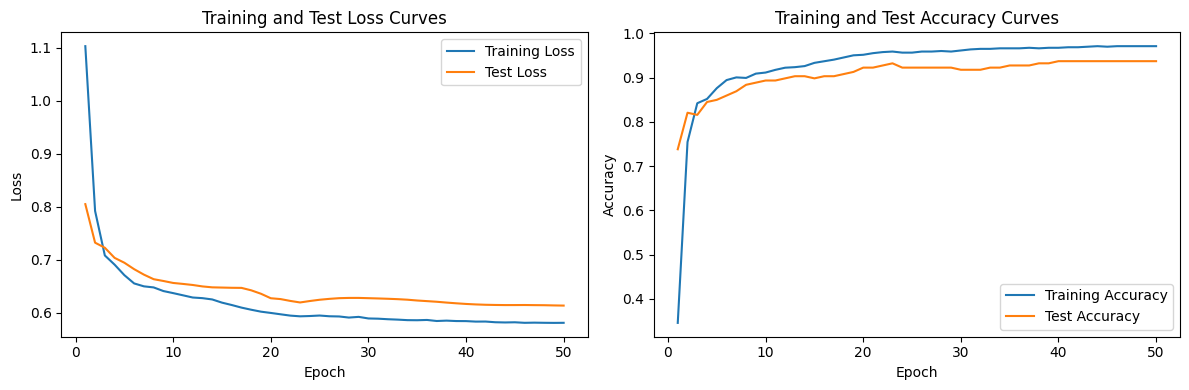

Training complete!


In [199]:
# Step 7: Training the Neural Network with Test Printing
print("Step 7: Training the Neural Network with Test Printing")

# Initialize lists to store training and test metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    # Training
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / y_train.size(0)

    # Testing
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct = (test_predicted == y_test).sum().item()
        test_accuracy = test_correct / y_test.size(0)

    # Log metrics
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(accuracy)
    test_accuracies.append(test_accuracy)

    # Print the training and testing information
    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch+1} | Loss: {loss.item():.5f}, Acc: {accuracy * 100:.2f}% | Test Loss: {test_loss.item():.5f}, Test Acc: {test_accuracy * 100:.2f}%')

def plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    # Plot Learning Curves
    plt.figure(figsize=(12, 4))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss Curves')

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy Curves')

    plt.tight_layout()
    plt.show()

    print("Training complete!")

plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies)

In [200]:

# Convert the test data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Evaluation (Forward pass) on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

# Calculate accuracy
correct = (predicted == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 93.69%


C:\Users\meike\AppData\Local\Temp\ipykernel_21540\1582262253.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\meike\AppData\Local\Temp\ipykernel_21540\1582262253.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


Weighted F1 Score on Test Set: 0.9378


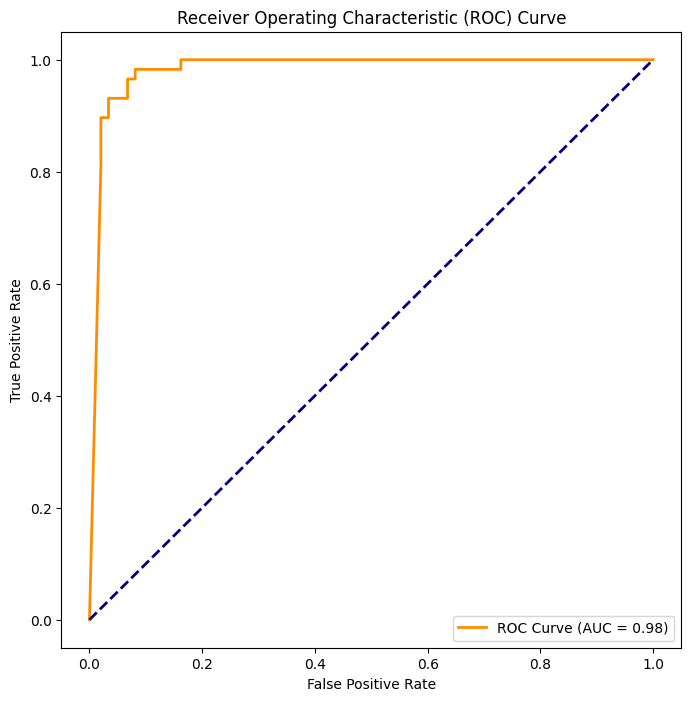

In [201]:

model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_labels = torch.max(test_outputs, 1)

f1 = f1_score(y_test, predicted_labels, average='weighted')
print(f'Weighted F1 Score on Test Set: {f1:.4f}')

# Plot ROC Curve
probs = torch.nn.functional.softmax(test_outputs, dim=1).numpy()
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [202]:

# Calculate Precision and Recall
precision = precision_score(y_test, predicted_labels, average=None)
recall = recall_score(y_test, predicted_labels, average=None)

# Print Precision and Recall for each class
for i, (prec, rec) in enumerate(zip(precision, recall)):
    print(f'Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}')


Class 0: Precision = 0.8333, Recall = 0.9524
Class 1: Precision = 0.8852, Recall = 0.9310
Class 2: Precision = 0.9835, Recall = 0.9370


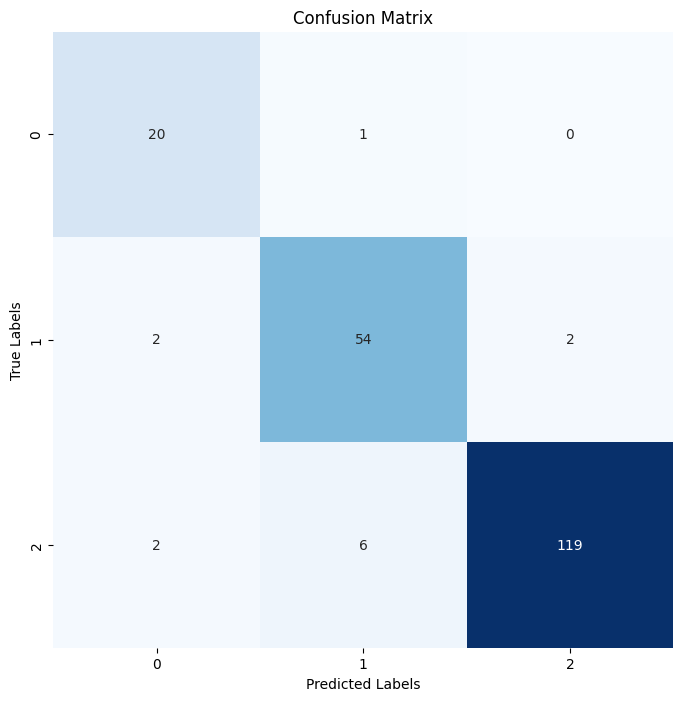

In [203]:

conf_matrix = confusion_matrix(y_test, predicted_labels)
# Visualize Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
